In [3]:
# DO NOT MODIFY
import nbimporter
import cv2

import matplotlib.pyplot as plt
import scipy.io as io
import numpy as np

from q2 import briefLite, briefMatch, plotMatches
import skimage.io

## Question 3: Homography Computation (30 pts)

### 3.1 Computing the Homography (10 points)

Write a function $\texttt{computeH}$ that estimates the planar homography from a set of matched point pairs.

\begin{equation}
\texttt{function [H2to1] = computeH(p1, p2)}
\end{equation}

$\texttt{p1}$ and $\texttt{p2}$ are $2\times N$ matrices containing the coordinates $(x, y)$ of point pairs between the two images. $\texttt{H2to1}$ should be a $3\times 3$ matrix for the best homography from image 2 to image 1 in the least-square sense. This should follow from your matrix as derived in **Q 1.2**. For the solver, feel free to use whatever you like. Although the [svdnotes]() (SVD notes in at the end of this handout) are one of the more straightforward methods.

In [47]:
def computeH(p1, p2):
    """
    Compute the homography matrix from point correspondences.
    
    INPUTS:
        p1 and p2 - Each are size (2 x N) matrices of corresponding (x, y)'  
                 coordinates between two images
    OUTPUTS:
     H2to1 - a 3 x 3 matrix encoding the homography that best matches the linear 
            equation
    """
    assert p1.shape[1] == p2.shape[1]
    assert p1.shape[0] == 2
    # YOUR CODE HERE
    
    A = list()# 2N 9
    
    for xp, yp, x, y in zip(p1[0], p1[1], p2[0], p2[1]):
        A.append([ -x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([ 0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])
    
    A = np.array(A)
    matrix = A.T @ A
    u, s, vh = np.linalg.svd(matrix, full_matrices=True)
    eigen_vector = vh[:,-1]
    H2to1 = eigen_vector.reshape(3,3)
    print(s)
    return H2to1

In [40]:
### HIDDEN TEST CELL
# Hint: Be careful that your homography matrix should be a mapping from
# p2 to p1: p1 = H*P2
im1 = cv2.imread("data/incline_L.png")
im2 = cv2.imread("data/incline_R.png")

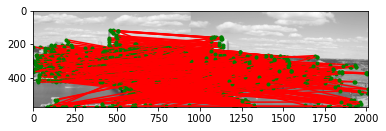

[1.60827227e+14 1.16992450e+13 3.36219116e+08 5.98101067e+07
 2.88996177e+07 2.04647805e+07 4.09173038e+06 4.78341443e+01
 7.78761395e+00]


In [93]:
locs1, desc1 = briefLite(im1)
locs2, desc2 = briefLite(im2)

matches = briefMatch(desc1, desc2, ratio=0.8)
plotMatches(im1, im2, matches[:50], locs1, locs2)
H = computeH(locs1[matches[:,0]].T, locs2[matches[:,1]].T)

In [100]:
H

array([[ 1.63780451e-03, -1.48082526e-03,  2.56759001e-02],
       [ 5.98532139e-02,  1.21613485e-02,  9.94827447e-01],
       [-7.69534366e-02,  3.39333428e-05,  1.44407232e-03]])

In [99]:
h

array([[ 2.00374227e-01, -1.10734991e+00,  3.63506223e+02],
       [ 2.10352847e-01, -1.16718128e+00,  3.83110132e+02],
       [ 5.51259381e-04, -3.04750192e-03,  1.00000000e+00]])

In [98]:
h, status = cv2.findHomography(locs1[matches[:,0]], locs2[matches[:,1]])

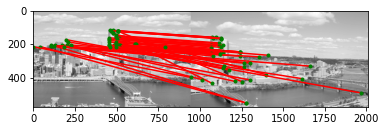

In [94]:
plotMatches(im1, im2, matches[:50], locs1, locs2)

### 3.2 RANSAC (10 points)

The RANSAC algorithm can generally fit any model to noisy data. You will implement it for (planar) homographies between images.

Write a function:

\begin{equation}
\texttt{function [bestH2to1, inliers] = computeH_ransac(locs1, locs2)}
\end{equation}

where $\texttt{bestH2to1}$ should be the homography $\mathbf{H}$ with most inliers found during RANSAC.  $\mathbf{H}$ will be a homography such that if $\mathbf{p}_2$ is a point in $\texttt{locs2}$ and  $\mathbf{p}_1$ is the corresponding point in $\texttt{locs1}$, then $\mathbf{p}_1 \equiv \mathbf{Hp}_2$. $\texttt{locs1}$ and $\texttt{locs2}$ are $N\times 2$ matrices containing the matched points. $\texttt{inliers}$ is a vector of length $N$ with a 1 at those matches that are part of the consensus set, and 0 elsewhere.

In [1]:
def computeH_ransac(matches, locs1, locs2, num_iter=5000, tol=2):
    """
    Returns the best homography by computing the best set of matches using RANSAC.
    
    INPUTS
        matches - matrix specifying matches between these two sets of point locations
        locs1 and locs2 - matrices specifying point locations in each of the images
        num_iter - number of iterations to run RANSAC
        tol - tolerance value for considering a point to be an inlier

    OUTPUTS
        bestH2to1 - homography matrix with the most inliers found during RANSAC
        inliers - a vector of length N (len(matches)) with 1 at the those matches
                  that are part of the consensus set, and 0 elsewhere.
    """
    p1 = locs1[matches[:, 0], :]
    p1 = np.transpose(p1)
    p2 = locs2[matches[:, 1], :]
    p2 = np.transpose(p2)
    p2_homo = np.concatenate((p2, np.ones([1, p2.shape[1]])), axis=0)
    
    # Hint: For each iteration, sample 4 point pairs for solving H using "computeH()".
    # Then, compute the number of inliers using the threshold. Finally, pick the H with
    # the most inliers.
    # Note: Please don't fix the random seed.  We need to use different random seeds to
    # validate your implementation.
    # YOUR CODE HERE
    maxinlier = 0
    inliers = None
    bestH2to1 = None
    for i in range(num_iter):
        random_select = np.random.choice(p1.shape[1], 4)
        ranH = computeH(p1[:, random_select], p2[:, random_select])
        project_points = ranH @ p2_homo
        image_pixel = project_points[:2, :] / project_points[2,:]
        error = ((p1 - image_pixel) ** 2).mean(0)
        temp_inliers = (error < tol).astype(int)
        num_inliers = temp_inliers.sum()
        if num_inliers > maxinlier:
            maxinlier = num_inliers
            inliers = temp_inliers
            bestH2to1 = ranH
    
    
    return bestH2to1, inliers

In [114]:
### HIDDEN TEST CELL
# Hint: When the number of iteration is small (e.g. 10), ideally, the number of inliers
# should not be always the same if you call "computeH_ransac()" several times.
im1 = cv2.imread("data/incline_L.png")
im2 = cv2.imread("data/incline_R.png")

In [95]:
# locs1, desc1 = briefLite(im1)
# locs2, desc2 = briefLite(im2)
# # matches = briefMatch(desc1, desc2, ratio=0.5)

# p1 = locs1[matches[:, 0], :]
# p1 = np.transpose(p1)
# p2 = locs2[matches[:, 1], :]
# p2 = np.transpose(p2)
# p2_homo = np.concatenate((p2, np.ones([1, p2.shape[1]])), axis=0)

# project_points = H @ p2_homo
# image_pixel = project_points[:2, :] / project_points[2,:]
# print(image_pixel[:,:10])
# print(p1[:,:10])

[[ 1.99304102e-04 -2.74047604e-03 -6.52977535e-04 -5.69355428e-03
  -5.30419080e-03 -5.30419080e-03  4.27250360e-03  4.20710164e-02
  -5.75240600e-03 -1.15786787e-03]
 [-1.07931386e+00 -1.03729118e+00 -1.06485120e+00 -9.92900039e-01
  -9.97076354e-01 -9.97076354e-01 -1.03937076e+00 -1.42323881e+00
  -9.40326917e-01 -1.03753161e+00]]
[[460 478 467 508 507 507 511 476 476 495]
 [117 117 119 120 122 123 123 135 135 147]]


In [89]:
# num_iter = 5000
# tol = 2

# maxinlier = 0
# inliers = None
# for i in range(num_iter):
#     random_select = np.random.choice(p1.shape[1], 4)
#     ranH = computeH(p1[:, random_select], p2[:, random_select])
# #     ranH = computeH(p1, p2)
#     project_points = ranH @ p2_homo
#     image_pixel = project_points[:2, :] / project_points[2,:]
#     error = ((p1 - image_pixel) ** 2).mean(0)
#     temp_inliers = (error < tol).astype(int)
#     num_inliers = temp_inliers.sum()
#     if num_inliers > maxinlier:
#         maxinlier = num_inliers
#         inliers = temp_inliers

[4.25621673e+11 5.41332607e+10 1.31436667e+06 1.88519986e+05
 1.11239921e+05 1.54417323e+04 2.10567159e+02 7.36508948e-03
 6.33807312e-11]
[3.30819726e+11 1.85499239e+09 7.92420885e+05 1.51513570e+04
 1.09588502e+04 4.35026447e+03 1.34919684e+01 5.08828936e-03
 3.26351034e-12]
[3.05307686e+11 3.58427022e+09 8.24380244e+05 3.23867967e+04
 1.09114287e+04 2.19820991e+03 1.29694471e+01 5.41987098e-04
 6.19431431e-11]
[7.34960592e+11 2.63678509e+10 1.07661708e+06 5.60781125e+04
 1.18066567e+04 3.44842474e+03 2.06620363e+02 4.27509240e-03
 2.87932966e-11]
[3.49394345e+11 4.61981464e+09 7.47969067e+05 5.74774648e+04
 1.33065561e+04 6.78838879e+03 8.44174907e+01 5.33742090e-03
 1.17566077e-11]
[3.72749511e+11 2.47688100e+10 7.60806732e+05 8.41570701e+04
 2.89926644e+04 8.01389739e+02 3.12528502e+02 1.35178642e-04
 2.25001256e-11]
[4.14412336e+11 8.78677434e+09 8.90161036e+05 6.46226724e+04
 1.44414209e+04 3.19429549e+03 4.93656891e+01 1.43240037e-02
 9.03245761e-11]
[6.86658928e+11 2.13289085e

[8.91053080e+11 2.22683857e+10 1.13348266e+06 1.23919035e+05
 7.09944095e+03 2.15411770e+03 3.67488279e+01 1.95103748e-03
 2.90363021e-12]
[1.05708374e+12 7.07547612e+10 2.63181138e+06 3.26740284e+05
 1.39543778e+05 5.05530983e+04 9.89979453e+02 6.18675690e-02
 1.34354667e-10]
[3.87222560e+11 2.91990012e+10 8.57935427e+05 9.07024617e+04
 1.42520029e+03 1.84553675e+02 5.20399373e+01 1.07708013e-05
 1.02266598e-11]
[1.10275203e+12 9.67334503e+10 1.79041251e+06 2.42212417e+05
 2.84383805e+04 2.01876183e+04 4.70094688e+02 1.21551131e-03
 7.06399385e-11]
[4.21139019e+11 4.09381834e+10 6.82663034e+05 7.05907684e+04
 4.58016414e+04 1.85206855e+03 9.56771354e+02 7.12705192e-02
 3.99262572e-11]
[5.84562133e+11 6.50048017e+09 1.04161056e+06 1.68853949e+04
 3.68580414e+03 1.01214029e+02 1.74161812e+00 3.49276412e-05
 1.56882940e-11]
[7.41148951e+11 1.48906128e+10 1.96882449e+06 2.98520697e+05
 3.89645802e+04 7.34168490e+03 4.44633726e+01 8.02326000e-07
 4.37126827e-10]
[1.64043705e+12 4.76074907e

[5.68628470e+11 6.52375768e+09 1.07736785e+06 1.28459464e+04
 1.05232402e+04 5.49825366e+03 6.92602866e+00 8.79155505e-05
 4.11572232e-11]
[3.81395646e+11 9.08720233e+09 8.12630953e+05 3.70429265e+04
 2.66986715e+04 1.31050239e+03 2.08574370e+01 3.19200122e-04
 6.52115866e-11]
[4.76307982e+11 1.63290744e+10 9.56906909e+05 6.15248098e+04
 4.88809817e+04 1.94430099e+03 3.20718509e+02 1.17585541e-05
 6.53967074e-12]
[5.88980731e+11 2.48138189e+10 9.36860874e+05 9.54369407e+04
 5.21912243e+04 5.00099777e+03 7.71512583e+02 7.01944344e-04
 1.03053607e-10]
[4.36412920e+11 3.29550210e+08 9.04549159e+05 1.77236385e+04
 1.54054590e+03 2.47856927e+02 1.19668904e-01 3.92025602e-05
 5.70923330e-11]
[4.56368268e+11 7.01641886e+09 9.67065604e+05 1.72861804e+04
 9.93040591e+03 5.12012945e+03 1.77498233e+01 5.17835699e-03
 3.29244453e-11]
[1.07331756e+12 6.98099947e+10 1.82965889e+06 1.55162481e+05
 3.54420242e+04 6.81766680e+03 6.01499982e+00 2.44118791e-04
 1.00560934e-10]
[3.90477199e+11 1.55776503e

[5.04394859e+11 6.44514576e+10 1.22437304e+06 2.81109890e+05
 7.00749274e+04 3.12153271e+04 7.18824789e+02 1.44887714e-02
 6.42730028e-10]
[4.02649133e+11 4.23134079e+09 8.29545724e+05 1.49343396e+04
 2.63811428e+03 4.02886287e+01 7.36089157e+00 5.42296087e-05
 4.44443301e-11]
[7.08015001e+11 2.41408218e+10 1.08160882e+06 5.01413445e+04
 3.22651301e+04 9.81733938e+02 4.34885521e-07 2.32655589e-10
 1.58216808e-12]
[1.21755474e+12 3.92952546e+10 1.97533848e+06 7.39710118e+04
 5.80197742e+04 1.97213090e+04 1.11891295e+02 3.41104716e-02
 1.14125088e-10]
[6.30765670e+11 2.23084361e+10 9.31630527e+05 5.91299831e+04
 3.05650670e+04 2.88137890e+03 6.41799012e+02 1.18576362e-03
 1.11432925e-10]
[6.63838577e+11 2.27034591e+10 9.47672705e+05 8.44753436e+04
 4.40153795e+04 2.90149803e+03 9.49853318e+02 1.86283932e-04
 2.17406507e-10]
[1.02731547e+12 3.91833763e+10 1.80447411e+06 1.14368700e+05
 3.71851893e+04 7.58335143e+03 2.43896309e+02 4.24852721e-02
 2.41936813e-09]
[5.69937615e+11 2.25573570e

 1.81847978e-11]
[5.49649252e+11 5.34345199e+10 9.01841972e+05 1.35697549e+05
 7.42911337e+04 4.47527143e+03 1.43179664e+03 8.09126011e-07
 1.69912655e-11]
[6.66216923e+11 1.24233958e+10 1.08358919e+06 3.02043053e+04
 6.27083735e+03 3.29996010e+02 2.64249609e+01 1.42455249e-07
 1.55744752e-11]
[1.65615425e+12 1.06992978e+11 1.79662345e+06 2.34019070e+05
 1.94916576e+05 9.40496069e+03 2.43637264e+03 3.04451195e-01
 6.11415988e-11]
[5.68301422e+11 2.75743502e+10 1.27335591e+06 1.08358251e+05
 6.66046354e+04 1.94723100e+04 2.80204072e+03 5.36609150e-02
 3.88081551e-10]
[6.69452479e+11 2.08621007e+10 1.04140932e+06 5.37056435e+04
 3.26882040e+04 8.97204678e+02 4.81787172e+02 2.05297393e-03
 4.13062743e-11]
[6.51162058e+11 6.01643911e+10 9.70890612e+05 1.39152616e+05
 4.69594145e+04 2.32559127e+03 4.66556832e+02 5.89874794e-03
 3.82278481e-11]
[7.41066130e+11 4.02281073e+10 1.01176375e+06 1.31649480e+05
 2.96464157e+04 1.04128839e+03 1.18552448e+02 3.83102763e-05
 9.62682193e-11]
[4.8544787

[3.45820463e+11 1.85840899e+10 7.38013897e+05 6.34077130e+04
 7.49076585e+03 1.27289082e+02 3.31546330e+01 3.99964202e-05
 9.06507888e-12]
[5.40697334e+11 4.03117885e+10 8.96523378e+05 1.25889435e+05
 3.03188776e+04 2.01214933e+03 5.53926850e+00 2.45527853e-04
 2.19130819e-11]
[3.52453713e+11 1.68575965e+10 9.93746628e+05 3.98868876e+05
 6.27968171e+04 4.05294500e+03 7.97098688e+01 8.00532434e-03
 6.97296479e-11]
[8.07760971e+11 4.91858137e+10 1.90333320e+06 4.08968862e+05
 9.55867332e+04 7.25411734e+04 1.22144766e+03 6.50446515e-02
 3.92995715e-11]
[8.85527425e+11 3.31644692e+10 1.24582802e+06 7.02975152e+04
 7.90923249e+03 1.70575519e+02 5.02550129e+01 7.48220297e-05
 1.49089309e-10]
[6.24066424e+11 1.98066922e+10 1.10609974e+06 6.59071416e+04
 3.14961863e+04 2.17194280e+03 2.54835278e+01 1.58138348e-05
 5.60092217e-11]
[9.69456206e+11 5.02446313e+10 2.00061738e+06 2.13199670e+05
 6.90086567e+04 6.84840023e+03 1.86639585e+03 2.21369598e-03
 1.21534815e-10]
[7.15717780e+11 2.33647791e

[5.37027177e+11 3.34304231e+10 9.74309112e+05 7.59359797e+04
 5.53495612e+03 6.18262268e+02 1.85282407e+02 2.55116618e-06
 2.55812766e-11]
[8.89674678e+11 6.69601097e+10 1.99560768e+06 2.30917083e+05
 9.48203218e+04 1.81083832e+04 5.68812058e+03 1.85758705e-02
 6.71803729e-10]
[9.33265957e+11 7.05057242e+10 1.24178863e+06 1.56724983e+05
 1.34674785e+04 1.37196722e+03 4.41361827e+01 2.81873682e-03
 3.75993897e-11]
[3.28848605e+11 1.41299388e+10 8.06581464e+05 4.75416573e+04
 9.56596552e+03 6.36681927e+02 6.46188741e+01 7.10319106e-04
 5.09001365e-11]
[5.04367286e+11 1.52997490e+10 9.77100671e+05 4.20009907e+04
 3.31265195e+04 4.39034626e+03 5.40895438e+01 1.11620938e-03
 2.97284260e-11]
[5.62222454e+11 2.34114490e+10 8.57237988e+05 6.18330349e+04
 4.68827961e+04 1.19236736e+03 8.95998313e+02 2.56656869e-03
 1.89408567e-10]
[4.52294099e+11 5.79192261e+09 8.99452159e+05 5.64726938e+04
 1.31115285e+04 1.61523265e+03 2.04490830e+01 7.42246105e-04
 1.22608628e-11]
[9.34635737e+11 4.40510547e

[5.17257833e+11 3.08956542e+10 8.20047361e+05 7.62329993e+04
 2.36871908e+04 2.49040114e+03 5.53394450e+02 2.74166609e-05
 1.28968897e-11]
[8.39257951e+11 6.45796310e+09 1.20719235e+06 1.89788418e+04
 8.70390274e+03 2.59238188e+03 1.07114733e+02 1.17580584e-03
 5.78961879e-10]
[7.00099833e+11 1.35559780e+10 9.84492035e+05 8.69330238e+04
 2.55842850e+04 1.47822440e+03 2.20767943e+02 8.82386484e-03
 8.62888852e-11]
[6.37721959e+11 1.19584530e+10 1.01375657e+06 2.97804363e+04
 9.50467777e+03 1.43563126e+03 8.46525271e+01 1.15466723e-04
 2.07025748e-11]
[6.57825979e+11 2.49530063e+10 1.14852433e+06 7.32297053e+04
 3.02607857e+04 1.62732067e+03 1.84242184e+01 6.54912964e-05
 8.18318687e-11]
[4.18481558e+11 4.04359543e+10 8.11407181e+05 1.08816254e+05
 3.18248880e+04 2.87750426e+03 1.05906018e+03 2.86264861e-06
 3.57447675e-13]
[4.28125626e+11 1.39850339e+09 9.41540547e+05 8.94767612e+03
 3.74592720e+03 2.92651123e+02 4.08198179e-08 4.12765321e-11
 2.86590192e-13]
[3.45998810e+11 1.03773248e

[2.88520972e+11 4.71260521e+09 7.11671663e+05 5.46491092e+04
 2.55342255e+04 8.60421421e+03 1.17572600e+02 2.50230766e-02
 5.01610318e-11]
[8.07778635e+11 3.89999409e+10 1.09247595e+06 1.02210373e+05
 1.31563741e+04 3.14736892e+03 2.50940304e-01 7.30031496e-03
 1.27907735e-11]
[5.03365375e+11 2.78539447e+10 8.97127630e+05 6.72395827e+04
 1.81823927e+04 1.12444066e+03 2.25445854e+02 1.53845017e-04
 1.00143983e-11]
[4.53218984e+11 3.52054905e+10 9.04075471e+05 1.07771816e+05
 2.56054828e+04 4.06464462e+03 4.95264627e+02 1.29778274e-03
 4.14095516e-11]
[5.42467820e+11 5.99010118e+09 1.00675042e+06 2.33773336e+04
 1.65297554e+04 3.44936746e+02 2.12777017e+01 1.96937095e-04
 7.31469301e-11]
[5.32002070e+11 2.60169077e+10 1.00281688e+06 1.08724855e+05
 3.23667317e+04 1.65067217e+04 4.09615386e+02 1.87616082e-04
 6.43112421e-11]
[1.83147389e+12 1.14620223e+11 2.04436547e+06 1.84916123e+05
 5.02061863e+04 6.97999819e+03 2.14539566e+02 3.70159714e-02
 1.39969818e-10]
[3.39157767e+11 4.67433813e

[7.09489550e+11 2.15078266e+10 1.17513516e+06 6.19077087e+04
 3.99980346e+04 1.93920740e+03 4.17552759e+02 5.98229875e-07
 3.45228554e-11]
[7.86456415e+11 2.80539415e+10 1.15991117e+06 5.38328401e+04
 3.41496594e+03 3.56018995e+02 1.90345393e+01 1.02430278e-07
 1.57442395e-10]
[8.19005349e+11 6.62196416e+10 1.24966920e+06 1.24998431e+05
 5.10694371e+03 1.12638803e+03 1.62387573e+02 3.25816111e-05
 1.76182869e-11]
[3.90097681e+11 3.35136851e+10 7.75548200e+05 8.32847567e+04
 6.29163333e+02 4.37772131e+02 3.37238500e+01 3.21564080e-06
 3.63761500e-11]
[7.77715310e+11 2.36743267e+10 1.13550513e+06 5.36491143e+04
 1.19881242e+04 2.34930460e+02 2.62832542e+01 7.60770259e-04
 1.21168974e-10]
[6.61905995e+11 6.57242481e+10 1.24736338e+06 1.76159871e+05
 3.72225283e+04 7.13978150e+03 6.18752200e+02 2.69951109e-02
 8.00026692e-12]
[2.77984107e+11 1.35539293e+10 6.22752509e+05 9.74962245e+04
 5.59358749e+04 1.50684424e+04 8.99924807e+02 2.43285291e-02
 8.16540101e-12]
[4.75695269e+11 6.73568948e

[6.71771725e+11 6.15808807e+10 1.00514786e+06 1.50718163e+05
 1.54294072e+04 2.99118717e+03 3.03630241e+01 4.47320941e-05
 8.69271481e-12]
[5.32297861e+11 3.44441618e+10 9.20792889e+05 9.60612357e+04
 6.14001895e+04 2.52527875e+03 2.67131706e+02 5.50725990e-03
 5.78492319e-11]
[5.68081472e+11 1.70014725e+10 9.81188432e+05 5.17199026e+04
 3.11710645e+04 1.69106929e+03 2.23836239e+01 4.14560053e-02
 1.06017418e-11]
[4.92963999e+11 2.00622527e+10 7.00239802e+05 5.81739035e+04
 2.79947877e+04 6.15657795e+02 5.80837284e+02 5.56843137e-06
 2.56032782e-10]
[3.81466645e+11 3.07328770e+10 7.50378732e+05 1.11955803e+05
 4.67922048e+04 1.17504054e+04 4.60185359e+02 5.44077961e-03
 5.30138307e-11]
[6.49477384e+11 6.52655718e+09 1.38183262e+06 5.24480180e+05
 2.22250733e+04 2.64941977e+02 5.50709695e-07 4.71763471e-11
 5.55803828e-13]
[7.34272976e+11 4.23587213e+10 2.01216234e+06 2.31511346e+05
 1.39597364e+05 3.28407598e+04 8.62717987e+01 2.14801184e-02
 9.10559838e-11]
[5.40352850e+11 8.69826195e

[6.86484152e+11 5.30554533e+10 1.57531482e+06 2.08625532e+05
 1.38506177e+05 3.32877399e+04 6.45449909e+02 4.56743489e-03
 3.07371154e-11]
[4.57351610e+11 2.40854493e+10 9.21305519e+05 7.96452712e+04
 1.21351698e+04 6.42314616e+03 1.71588363e+02 4.61226139e-03
 1.87302491e-11]
[5.05129173e+11 8.38557979e+09 9.11292303e+05 7.19078668e+04
 9.43911440e+03 6.86424679e+03 1.77115471e+01 3.95052962e-04
 7.91917925e-11]
[4.23356289e+11 2.54395981e+09 8.27910233e+05 6.77785040e+04
 9.41412551e+03 6.47000538e+02 8.18881159e-09 7.27164300e-10
 9.20965078e-12]
[7.73978947e+11 8.87248529e+10 1.80200758e+06 2.10698393e+05
 8.77709578e+04 1.97772799e+04 8.04114898e+01 1.67026152e-02
 9.73527510e-11]
[7.35834400e+11 4.56764295e+09 1.11805181e+06 1.02370586e+04
 6.12265125e+03 7.08859153e+01 1.89553652e+01 3.60186362e-06
 1.67598579e-10]
[5.75757145e+11 1.44745991e+10 8.48041571e+05 1.61651928e+05
 3.36869915e+04 1.93930097e+04 1.20785989e+03 1.57185958e-05
 5.89737208e-11]
[9.30895923e+11 1.82410663e

[7.00995656e+11 3.38310966e+10 1.04691044e+06 8.92678239e+04
 7.96443607e+03 1.43305488e+03 1.97330295e+01 3.63582242e-04
 7.68882386e-11]
[5.73656554e+11 4.94028893e+10 9.61719220e+05 1.07767517e+05
 6.87287564e+04 2.82910528e+03 7.50329523e+01 4.58245348e-05
 3.31725193e-11]
[9.52554939e+11 3.41706971e+10 1.16812466e+06 9.43037996e+04
 1.50737055e+04 9.06707972e+02 8.53145614e+01 4.97682660e-04
 1.92610343e-10]
[5.81211418e+11 6.73712398e+10 1.07001096e+06 1.66751325e+05
 1.33751049e+05 3.62163679e+03 9.14882310e+01 2.21849781e-01
 2.64260302e-11]
[6.63786683e+11 4.77478332e+10 1.03310155e+06 1.17931594e+05
 2.89022664e+04 3.84954929e+03 7.29538373e+02 5.82237583e-04
 9.84652117e-11]
[6.57004965e+11 1.50279868e+10 1.18229326e+06 3.00964882e+05
 4.26812225e+04 3.26839783e+03 2.47362446e+01 1.16508047e-03
 8.44573651e-10]
[9.68415297e+11 2.80424470e+10 1.29005953e+06 6.92296009e+04
 1.17791613e+04 1.62636764e+03 1.44026308e+02 1.04513571e-04
 8.44651707e-11]
[5.84384776e+11 6.09740971e

[2.14744116e+11 4.66047389e+09 7.46544766e+05 1.54767474e+05
 1.57078653e+04 8.70257638e+02 2.73325136e+00 2.19118363e-04
 2.36879876e-10]
[3.18676839e+11 1.87383164e+10 7.05355667e+05 7.59000579e+04
 3.46696563e+04 1.75664475e+03 3.78985987e+02 1.04984563e-03
 1.32210523e-12]
[3.47129380e+11 1.64359854e+10 7.71064420e+05 5.89934270e+04
 1.55658732e+04 4.05200694e+02 2.56110374e+02 1.61727937e-04
 2.92062087e-11]
[5.86844105e+11 2.11176060e+10 1.36219202e+06 2.11674294e+05
 1.06471347e+05 7.36733140e+03 6.20853287e+02 8.32748134e-03
 2.66308979e-11]
[1.09181997e+12 2.53045721e+10 1.84981953e+06 1.11103749e+05
 7.01021997e+04 3.45282487e+04 4.51686954e+02 3.09849274e-04
 2.17133909e-10]
[3.67021705e+11 1.23219933e+10 7.86272882e+05 4.55141920e+04
 3.56754150e+04 1.28894074e+03 2.46735814e+01 2.28495097e-04
 4.24688384e-11]
[6.16984364e+11 3.83703878e+10 9.54098882e+05 9.24812918e+04
 4.10279171e+04 1.65645037e+03 1.00441922e+03 3.45701841e-03
 8.75241447e-11]
[6.40444622e+11 6.79228947e

### 3.3 Automated Homography Estimation/Warping for Augmented Reality (10 points)

Implement the following steps: 
   1. Reads $\texttt{cv_cover.jpg}$, $\texttt{cv_desk.png}$, and $\texttt{hp_cover.jpg}$ from the "figure/" folder.
   2. Computes a homography automatically using $\texttt{computeH_ransac}$.
   3. Warps $\texttt{hp_cover.jpg}$ to the dimensions of the $\texttt{cv_desk.png}$ image using the OpenCV $\texttt{warpPerspective}$ function. 
   4. At this point you should notice that although the image is being warped to the correct location, it is not filling up the same space as the book. Why do you think this is happening? How would you modify $\texttt{hp_cover.jpg}$ to fix this issue?
   5. Implement the function: $\texttt{function [ composite_img ] = compositeH( H2to1, template, img) }$ to now compose this warped image with the desk image as in the following figures.
   6. **The question will be manually graded.** Include your resulting image in your write-up. Please also print the final H matrix in your writeup (normalized so the bottom right value is 1)
   
|<img align="center" src="figure/cv_desk.png" width="300"> | <img align="center" src="figure/hp_cover.jpg" width="150"> | <img align="center" src="figure/hp_desk.png" width="300">|
|:--:|:--:|:--:|
|(a) Text book.| (b) Harry Potter cover.| (c) HarryPotterized Text book|
|| Fig 3.1 Warping for augmented reality. | |


In [56]:
cv_cover = plt.imread('figure/cv_cover.jpg')
cv_desk = plt.imread('figure/cv_desk.png')
hp_cover = plt.imread('figure/hp_cover.jpg')
hp_desk = plt.imread('figure/hp_desk.png')
cv_desk_gray = cv2.cvtColor(cv_desk,cv2.COLOR_BGRA2GRAY)
hp_desk_gray = cv2.cvtColor(hp_desk,cv2.COLOR_BGRA2GRAY)

In [96]:
def plotMatchesGray(im1, im2, matches, locs1, locs2):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2 * 256
    plt.imshow(im, cmap='gray')
    for i in range(matches.shape[0]):
        pt1 = locs1[matches[i,0], 0:2]
        pt2 = locs2[matches[i,1], 0:2].copy()
        pt2[0] += im1.shape[1]
        x = np.asarray([pt1[0], pt2[0]])
        y = np.asarray([pt1[1], pt2[1]])
        plt.plot(x,y,'r')
        plt.plot(x,y,'g.')
    plt.show()

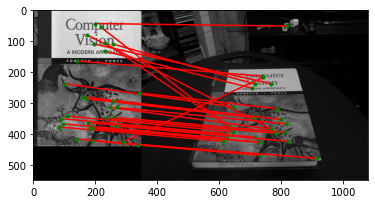

In [97]:
locs1, desc1 = briefLite(cv_cover)
locs2, desc2 = briefLite(cv_desk_gray)

matches = briefMatch(desc1.squeeze(), desc2.squeeze(), ratio=0.5)
plotMatchesGray(cv_cover, cv_desk_gray, matches, locs1, locs2)

In [ ]:
def compositeH(H, template, img):
    """
    Returns the composite image.
    
    INPUTS
        H - homography matrix [3x3]
        img - background image
        template - template image to be warped

    OUTPUTS
        composite_img - composite image
    """

    # ===============
    # Hint: Create a composite image after warping the template image on top
    # of the image using the homography

    # Note that the homography we compute is from the image to the template;
    # x_template = H2to1*x_photo
    # For warping the template to the image, we need to invert it.
    # ===============

    # YOUR CODE HERE
    raise NotImplementedError()
    return composite_img.astype(np.uint8)

### SVD Notes

The Singular Value Decomposition (SVD) of a matrix $\textbf{A}$ is expressed as:
\begin{equation*}
\mathbf{A} = U\Sigma V^T
\end{equation*}
Here, $U$ is a matrix of column vectors called the "left singular vectors". Similarly, $V$ is called the "right singular vectors". The matrix $\Sigma$ is a diagonal matrix. Each diagonal element $\sigma_i$ is called the "singular value" and these are sorted in order of magnitude. In our case, it is a $9\times9$ matrix.

   * If $\sigma_9 = 0$, the system is _exactly-determined_, a homography exists and all points fit exactly.
   * If $\sigma_9 \ge 0$, the system is _over-determined_. A homography exists but not all points fit exactly (they fit in the least-squares error sense). This value represents the goodness of fit.
   * Usually, you will have at least four correspondences. If not, the system is _under-determined_. We will not deal with those here.

The columns of $U$ are eigenvectors of $\mathbf{AA}^T$. The columns of $V$ are the eigenvectors of $\mathbf{A}^T\mathbf{A}$. We can use this fact to solve for **h** in the equation **Ah = 0**.
Using this knowledge, let us reformulate our problem of solving $\mathbf{Ax} = \mathbf{0}$. We want to minimize the error in solution in the least-squares sense. Ideally, the product $\mathbf{Ah}$ should be 0. Thus the sum-squared error can be written as:

\begin{equation}
f(\mathbf{h}) = \frac{1}{2}(\mathbf{Ah} - \mathbf{0})^{T}(\mathbf{Ah} - \mathbf{0})\\
              = \frac{1}{2}(\mathbf{Ah})^{T} (\mathbf{Ah})\\
              = \frac{1}{2}\mathbf{h}^T\mathbf{A}^T\mathbf{A}\mathbf{h}
\end{equation}

Minimizing this error with respect to **h**, we get:

\begin{equation}
\frac{d}{d\mathbf{h}}f = 0\\
\implies \frac{1}{2}(\mathbf{A}^T\mathbf{A} + (\mathbf{A}^T\mathbf{A})^T)\mathbf{h} = 0\\
\mathbf{A}^T\mathbf{Ah} = 0
\end{equation}

This implies that the value of **h** equals the eigenvector corresponding to the zero eigenvalue (or closest to zero in case of noise). Thus, we choose the smallest eigenvalue of $\mathbf{A}^T\mathbf{A}$, which is $\sigma_9$ in $\Sigma$ and the least-squares solution to **Ah = 0** is the the corresponding eigenvector (in column 9 of the matrix **V**).